<a href="https://colab.research.google.com/github/zenodante/AFMTools/blob/master/5DRAFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference

Once an ML model is trained, we can use it for segmentation of the original images in the dataset.  This process, of applying a trained model to new data, is called inference.

## Import necessary packages

In [ ]:
import numpy as np
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
import glob
import os

import torch
#import torchvision
#import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data as D
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
from skimage import measure, filters
from sklearn.preprocessing import OneHotEncoder
print(torch.__version__)
import time

save_name = 'pytorchtest/Inference'

1.5.1


## Define the Model

You need to redefine the model you want to use for inference before you load the trained weights. Criterion and optimizer are not used in inference since we're not training anything. However, their states are still saved in the weights' file so you need to define them again to avoid any bugs/errors.

Load the desired checkpoint from the `save_name` in the training script. the `eXX` at the end of the file shows the epoch you want to pick up from. 

<font color='green'>ACTION: Change this epoch number to the one with the lowest loss value. </font>

<font color='blue'>The four lines `device = torch.device('cuda:0,1,2,3' if torch.cuda.is_available() else 'cpu')`  , `print(device)`,  `model.to(device)`, and `model = nn.DataParallel(model)` should only be used if you are using a computer with one or more GPU's.</font>

In [ ]:
class autoencoder_bottle_large_shallow(nn.Module):
    def __init__(self):
        super(autoencoder_bottle_large_shallow,self).__init__()
        self.conv0 = nn.Conv2d(1,2,7,dilation=1,padding=3)
        self.b0 = nn.BatchNorm2d(2)
        self.conv1 = nn.Conv2d(2,8,7,dilation=1,padding=3)
        self.b1 = nn.BatchNorm2d(8)
        self.conv6 = nn.ConvTranspose2d(8,2,7,stride=2,padding=3)
        self.b6 = nn.BatchNorm2d(2)
        self.conv7 = nn.ConvTranspose2d(2,1,7,stride=2,padding=3)
        self.b7 = nn.BatchNorm2d(1)
        self.pool = nn.MaxPool2d(2,2)

        
    def forward(self,x):
        c0 = self.pool(self.b0(F.relu(self.conv0(x))))
        c1 = self.pool(self.b1(F.relu(self.conv1(c0))))
        c6 = self.b6(F.relu(self.conv6(c1,output_size=c0.size())))
        c7 = self.b7(F.relu(self.conv7(c6,output_size=x.size())))  
        return c7
    
model = autoencoder_bottle_large_shallow()  

criterion = nn.MSELoss() 

optimizer = optim.Adam(model.parameters(),lr = 0.0005) 


device = torch.device('cuda:0,1,2,3' if torch.cuda.is_available() else 'cpu')  
print(device)
model.to(device)
model = nn.DataParallel(model) 

checkpoint = torch.load('./pytorchtest/firsttest_e50.pt') 
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

cuda:0


DataParallel(
  (module): autoencoder_bottle_large_shallow(
    (conv0): Conv2d(1, 2, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (b0): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(2, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (b1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (b2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 2, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (b3): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): ConvTranspose2d(2, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (b4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): ConvTranspose2d(16, 8, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (b5):

## Preprocessing 
Normalize the images. Set up the dataloader that will feed images to the model just like in the training script. The batch size does not have to be the same as the batch size used for training. In this script, we use full sized images so each will occupy more GPU memory which is why we decreased the batch size. 

## Initializing

Create an empty array to hold processed image data.

## Evaluating

Loop through all batches of the data and run the trained machine learning model on the images. 

<font color='green'>ACTION: change the last two parameters of reshape to be the shape of the drift corrected images. If you did not use blur change `images[i] = norm(filters.gaussian(images[i],3))` to `images[1] = norm(images[i])`. </font>

<font color='blue'> The line `inputs = inputs.to(device)` sends input to the GPU and the line `out = model(inputs).detach().cpu().numpy()` runs the model on the data and detaches from the GPU. Remove these lines if training on a computer without a GPU. </font>

In [ ]:
start = time.time()
print('Loading Images')
!gdown --id 1Lelp1sSXeNtDpv0eIAnwak4dX4sGVb1T
images = np.load('/content/sample_data_small.npy',mmap_mode='r+').reshape(-1,1,-1,-1)  

print('Preprocessing')
def norm(im):
    return (im - np.min(im)) / (np.max(im) - np.min(im))

for i in range(len(images)):
    if i % 50 == 0:
        print('\t{} / {}'.format(i,len(images)))
    images[i] = norm(filters.gaussian(images[i],3)) 

print('\t',images.shape)
batch_size=16
tensor_im = torch.stack([torch.Tensor(i) for i in images])
dataset = torch.utils.data.TensorDataset(tensor_im)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=False)

print('Inference')
print('\tInitializing')
outputs = np.zeros_like(images) 

print('\tEvaluating')
for i, data in enumerate(dataloader,0): 
    print('\t {} / {}'.format(i*batch_size,len(images)))
    inputs = data[0]
    inputs = inputs.to(device) 
    
    out = model(inputs).detach().cpu().numpy()  
    outputs[i*batch_size:i*batch_size + batch_size] = out 

print('Finished!')
print('\tTime: ',time.time() - start)

Loading Images
Preprocessing
	0 / 755
	50 / 755
	100 / 755
	150 / 755
	200 / 755
	250 / 755
	300 / 755
	350 / 755
	400 / 755
	450 / 755
	500 / 755
	550 / 755
	600 / 755
	650 / 755
	700 / 755
	750 / 755
	 (755, 1, 3072, 3072)
Inference
	Initializing
	Evaluating
	 0 / 755
	 16 / 755
	 32 / 755
	 48 / 755
	 64 / 755
	 80 / 755
	 96 / 755
	 112 / 755
	 128 / 755
	 144 / 755
	 160 / 755
	 176 / 755
	 192 / 755
	 208 / 755
	 224 / 755
	 240 / 755
	 256 / 755
	 272 / 755
	 288 / 755
	 304 / 755
	 320 / 755
	 336 / 755
	 352 / 755
	 368 / 755
	 384 / 755
	 400 / 755
	 416 / 755
	 432 / 755
	 448 / 755
	 464 / 755
	 480 / 755
	 496 / 755
	 512 / 755
	 528 / 755
	 544 / 755
	 560 / 755
	 576 / 755
	 592 / 755
	 608 / 755
	 624 / 755
	 640 / 755
	 656 / 755
	 672 / 755
	 688 / 755
	 704 / 755
	 720 / 755
	 736 / 755
	 752 / 755
Finished!
	Time:  536.8986613750458


<font color='green'>ACTION: change the last two parameters of reshape to be the shape of the drift corrected images.</font>

<font color='red'>Do not save data if you are using the provided sample data

In [ ]:
np.save('800C_video_float32_out.npy',outputs.reshape(-1,3072,3072)) 

Use the following cell to visualize images and test results. 

<font color='green'>ACTION (OPTIONAL): Pick different values of n to change the image you are checking. </font>

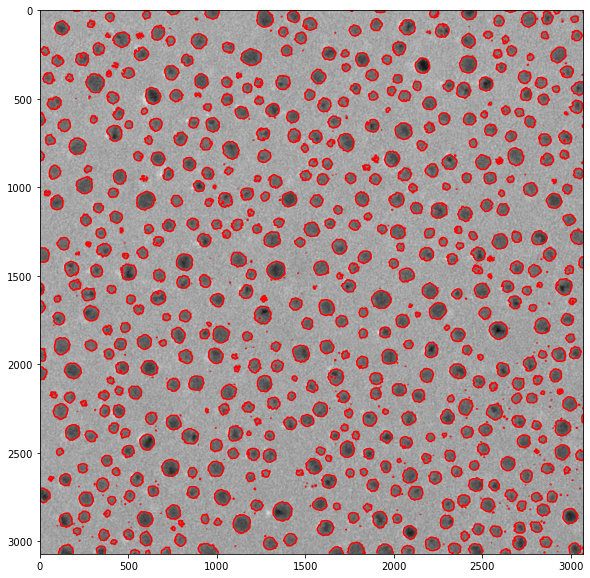

In [ ]:
f,a = plt.subplots(figsize=(10,10))
#n = int(np.random.rand()*len(outputs))
n = 341
a.imshow(images[n,0],plt.cm.gray)
a.contour(outputs[n,0],[filters.threshold_otsu(outputs[n,0])],colors=['red'])